### Extract LPI data

In [9]:
import pandas as pd
species = 'mouse'

lppi = pd.read_csv(f'../../annotate/{species}/valid_inter.csv')

lpi = lppi[lppi.iloc[:, 0].str.startswith('l')]
lpi = lpi[['source', 'target']]
lpi.columns = ['lncRNA_id', 'protein_id']
lpi.to_csv(f'{species}_lpi.csv', index=False)

### Extract mouse essenrial protein & human essential protein

In [ ]:
import pandas as pd

protein = pd.read_csv(f'../../data/LPPI/mouse/protein_updated.csv')
ess_protein = pd.read_csv('Mus musculus_genes.csv')

ess_protein = ess_protein[['gene', 'essentiality']]
ess_protein = ess_protein[(ess_protein['essentiality'] == 'E')]
ess_protein_lpi = protein[protein['protein'].isin(ess_protein['gene'])]
ess_protein_id = ess_protein_lpi['protein_id']

ess_protein_id.to_csv(f'mouse_ess_protein_id.csv', index=False)

In [5]:
import pandas as pd

protein = pd.read_csv('../../data/LPPI/human/protein_updated.csv')
ess_protein = pd.read_csv('CSEGs_CEGs.txt', sep='\t')

ess_protein = ess_protein[['gene', 'essentiality']]
ess_protein = ess_protein[ess_protein['essentiality'] == 'CEGs']

ess_protein_lpi = protein[protein['protein'].isin(ess_protein['gene'])]
ess_protein_id = ess_protein_lpi['protein_id']

ess_protein_id.to_csv(f'human_ess_protein_id.csv', index=False)

### Test the correlation between lncRNA essentiality and the essentiality of interacting proteins.

In [10]:
import pandas as pd
from scipy.stats import chi2_contingency
import os

species = 'human'

if species == 'mouse':
    tissues = ['heart', 'lung', 'brain']
    k = 50
    tissue_name_map = {
        "heart": "Heart",
        "lung": "Lung",
        "brain": "Forebrain"
    }
else:
    tissues = ['heart', 'lung', 'stomach']
    k = 30
    tissue_name_map = {
        "heart": "Left ventricle",
        "lung": "Left lung",
        "stomach": "Stomach"
    }

# Load essential proteins
essential_proteins = pd.read_csv(f'{species}_ess_protein_id.csv')
essential_protein_set = set(essential_proteins.iloc[:, 0])

# Load lncRNA-protein interaction pairs
interactions = pd.read_csv(f'{species}_lpi.csv')

# Define all lncRNAs appearing in interactions (as the universe)
all_lncrnas = set(interactions['lncRNA_id'])

# lncRNAs that interact with essential proteins
lnc_with_essentialP = set(
    interactions[interactions['protein_id'].isin(essential_protein_set)]['lncRNA_id']
)

# lncRNAs that do NOT interact with essential proteins
lnc_without_essentialP = all_lncrnas - lnc_with_essentialP

# Output file
output_file = f'{species}_lncrna_enrichment_chi2_result.txt'
if os.path.exists(output_file):
    os.remove(output_file)

for t in tissues:

    # Get full tissue name for writing
    full_name = tissue_name_map.get(t, t)

    # Load essential lncRNAs for this tissue
    ess_path = f'../ess_number/filtered/{species}/BC_top{k}pct_{species}_{t}_esslnc.csv'
    essential_lncrnas = pd.read_csv(ess_path, header=None)
    essential_lncrna_set = set(essential_lncrnas.iloc[:, 0])

    # Background for test: All lncRNAs excluding essential lncRNAs
    background_lncrna_set = all_lncrnas - essential_lncrna_set

    a_test = len(essential_lncrna_set & lnc_with_essentialP)
    b_test = len(background_lncrna_set & lnc_with_essentialP)
    c_test = len(essential_lncrna_set & lnc_without_essentialP)
    d_test = len(background_lncrna_set & lnc_without_essentialP)

    contingency_table_test = [[a_test, b_test], [c_test, d_test]]
    chi2, p_chi2, _, _ = chi2_contingency(contingency_table_test)

    prop_ess = a_test / (a_test + c_test) if (a_test + c_test) > 0 else 0
    prop_bg = b_test / (b_test + d_test) if (b_test + d_test) > 0 else 0
    enrichment = prop_ess / prop_bg if prop_bg > 0 else float('inf')

    # Display counts: Essential vs ALL lncRNAs
    a_all = a_test
    c_all = c_test
    b_all = len(all_lncrnas & lnc_with_essentialP)
    d_all = len(all_lncrnas & lnc_without_essentialP)

    with open(output_file, 'a', encoding='utf-8') as f:
        f.write(f"\n=== Tissue: {full_name} ===\n")
        f.write("Contingency Table (Displayed counts: Essential vs All lncRNAs):\n")
        f.write("                 | Interact_with_essP | No_interact_with_essP\n")
        f.write("-----------------|-------------------|-----------------------\n")
        f.write(f"Essential lncRNA | {a_all:7d}            | {c_all:7d}\n")
        f.write(f"All lncRNA       | {b_all:7d}            | {d_all:7d}\n\n")

        f.write(f"Chi2 statistic: {chi2:.6g}\n")
        f.write(f"Chi-squared test p-value: {p_chi2:.6g}\n\n")

        f.write("Proportion interacting with essential proteins (used in Chi-square test):\n")
        f.write(f"Essential:  {prop_ess:.3f}  ({a_test}/{a_test+c_test})\n")
        f.write(f"Background: {prop_bg:.3f}  ({b_test}/{b_test+d_test})\n")
        f.write(f"Enrichment (Essential / Background): {enrichment:.3f}\n")

print(f"\n✅ Results saved to {output_file}")



✅ Results saved to human_lncrna_enrichment_chi2_result.txt


### The interaction between the predicted essential lncRNA and the essential protein.

In [1]:
import pandas as pd
from scipy.stats import chi2_contingency, fisher_exact
species = 'mouse'

# Load essential proteins
essential_proteins = pd.read_csv(f'{species}_ess_protein_id.csv')
essential_protein_set = set(essential_proteins.iloc[:, 0])

# Load lncRNA-protein interaction pairs
interactions = pd.read_csv(f'{species}_lpi.csv')

# Load essential lncRNAs (must be provided)
essential_lncrnas = pd.read_csv(f'../../results/{species}/{species}_essential_genes_union.csv')

# Convert to set for faster lookup
essential_lncrna_set = set(essential_lncrnas.iloc[:, 0])

# lncRNAs interacting with essential proteins
lnc_with_essential = set(interactions[interactions['protein_id'].isin(essential_protein_set)]['lncRNA_id'])

# All interacting lncRNAs
all_lncrnas = set(interactions['lncRNA_id'])

# lncRNAs NOT interacting with essential proteins
lnc_without_essential = all_lncrnas - lnc_with_essential


# a: essential lncRNA & interacts with essential protein
a = len(essential_lncrna_set & lnc_with_essential)

# b: essential lncRNA & does NOT interacts with essential protein
b = len(essential_lncrna_set & lnc_without_essential)

# Output
print("The ratio of essential lncRNAs interacting with essential proteins is:", a / (a + b))



The ratio of essential lncRNAs interacting with essential proteins is: 0.7150176112712135


### The number of essential protein interact with lncRNA gene in benchmark dataset.

/tmp/ipykernel_455798/806364999.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/tmp/ipykernel_455798/806364999.py:64: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


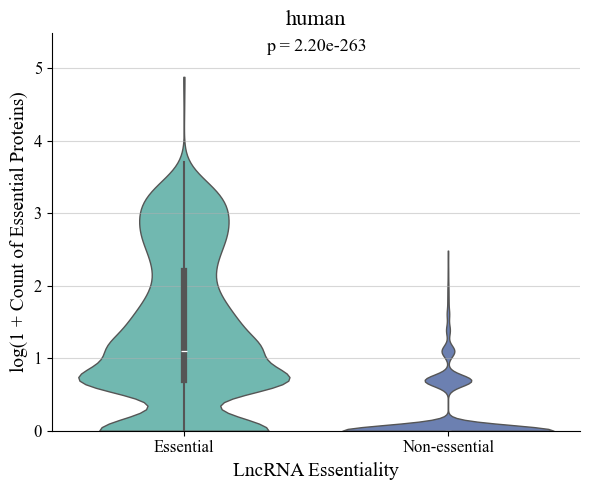

/tmp/ipykernel_455798/806364999.py:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(
/tmp/ipykernel_455798/806364999.py:64: FutureWarning: 

The `scale` parameter has been renamed and will be removed in v0.15.0. Pass `density_norm='width'` for the same effect.
  ax = sns.violinplot(


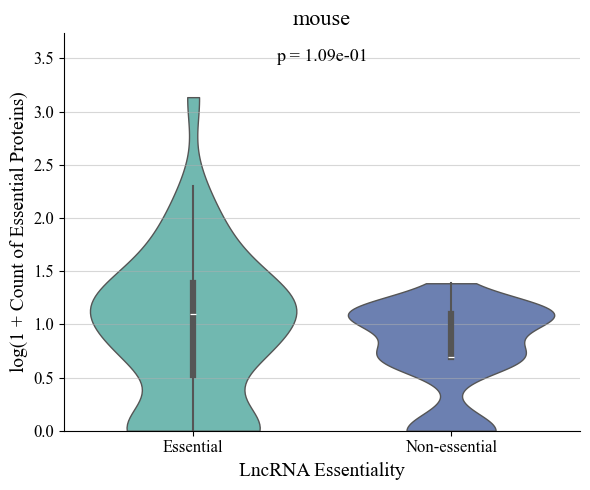

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from collections import defaultdict
from matplotlib import rcParams
import numpy as np

# Use Times New Roman
rcParams['font.family'] = 'Times New Roman'

# =====================
# Step 1: Load data
# =====================
for species in ['human','mouse']:
    interactions = pd.read_csv(f'{species}_lpi.csv')
    essential_proteins = pd.read_csv(f'{species}_ess_protein_id.csv')
    essential_lncrnas = pd.read_csv(f'../../data/benchmark/{species}/ess_lnc.csv')
    non_essential_lncrnas = pd.read_csv(f'../../data/benchmark/{species}/noness_lnc.csv')

    # =====================
    # Step 2: Build mapping
    # =====================
    essential_protein_set = set(essential_proteins.iloc[:, 0])
    essential_lncrna_set = set(essential_lncrnas.iloc[:, 0])
    non_essential_lncrna_set = set(non_essential_lncrnas.iloc[:, 0])

    protein_essential_map = {p: (p in essential_protein_set) for p in interactions['protein_id'].unique()}

    lnc_protein_map = defaultdict(list)
    for _, row in interactions.iterrows():
        lnc = row['lncRNA_id']
        prot = row['protein_id']
        lnc_protein_map[lnc].append(prot)

    # =====================
    # Step 3: Compute counts and log(count)
    # =====================
    data = []
    for lnc, proteins in lnc_protein_map.items():
        if len(proteins) == 0:
            continue
        ess_count = sum(protein_essential_map[p] for p in proteins)
        if lnc in essential_lncrna_set:
            label = 'Essential'
        elif lnc in non_essential_lncrna_set:
            label = 'Non-essential'
        else:
            continue
        data.append((lnc, ess_count, np.log1p(ess_count), label))

    df_count = pd.DataFrame(data, columns=['lncRNA', 'count', 'log_count', 'label'])

    # =====================
    # Step 4: Violin + jittered points (avoids "missing box")
    # =====================
    plt.figure(figsize=(6, 5))

    # Customize colors here if needed
    palette = {'Essential': '#65c4b9', 'Non-essential': '#607bbc'}  # change HEX as you like
    order = ['Essential', 'Non-essential']

    # Violin plot with an internal box to show quartiles
    ax = sns.violinplot(
        x='label', y='log_count', data=df_count,
        order=order, palette=palette,
        inner='box',      # show inner box for quartiles
        cut=0,            # do not extend beyond data range
        scale='width',    # same overall width for groups
        bw_adjust=0.8,    # smoothness; tweak if distribution is very discrete
        linewidth=1
    )

    # Titles and labels
    ax.set_title(f'{species}', fontsize=16)
    ax.set_ylabel('log(1 + Count of Essential Proteins)', fontsize=14)
    ax.set_xlabel('LncRNA Essentiality', fontsize=14)
    ax.tick_params(axis='both', labelsize=12)
    sns.despine()
    plt.grid(True, axis='y', linewidth=0.8, alpha=0.5)

    # =====================
    # Step 5: Mann–Whitney U test + annotate p-value
    # =====================
    group1 = df_count[df_count['label'] == 'Essential']['log_count']
    group2 = df_count[df_count['label'] == 'Non-essential']['log_count']
    stat, p_value = mannwhitneyu(group1, group2, alternative='two-sided')

    y_max = df_count['log_count'].max()
    y_loc = y_max + 0.3
    ax.text(0.5, y_loc, f"p = {p_value:.2e}", ha='center', va='bottom', fontsize=13)
    ax.set_ylim(0, y_loc + 0.3)

    plt.tight_layout()
    plt.savefig(f'{species}_log_essential_protein_count_violin.svg', format='svg', dpi=300, bbox_inches='tight')
    plt.show()
